# Fama-Macbeth Cross-sectional Regressions


_If you don’t risk anything, you risk even more_ – Erica Jong


The Fama-MacBeth (1973) cross-sectional regression methodology is a fundamental tool in empirical asset pricing, used to estimate risk factor loadings and associated risk premia while accounting for cross-sectional correlation in errors. By performing two-stage regressions, the method first estimates factor loadings for individual assets and then determines the associated risk premia over time. This approach has broad applications in testing asset pricing models, including the Capital Asset Pricing Model (CAPM) and multi-factor models. The following sections also analyze efficient frontier construction, Black-Litterman implied alphas and portfolio optimization, risk factor modeling, and non-linear regressions.


In [1]:
import numpy as np
from numpy import linalg as la
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.kernel_ridge import KernelRidge
import random
from tqdm import tqdm
import cvxpy as cp
from finds.database import SQL, RedisDB
from finds.structured import (BusDay, Signals, Benchmarks, CRSP,
                              CRSPBuffer, SignalsFrame)
from finds.backtesting import RiskPremium
from finds.recipes import winsorize, least_squares
from finds.readers import FFReader
from secret import credentials, paths, CRSP_DATE
VERBOSE = 0
#%matplotlib qt

In [2]:
# open connections
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
rdb = RedisDB(**credentials['redis'])
bd = BusDay(sql, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)
signals = Signals(user, verbose=VERBOSE)
bench = Benchmarks(sql, bd, verbose=VERBOSE)
imgdir = paths['images']
LAST_DATE = bd.endmo(CRSP_DATE, -1)

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Mean variance optimization

Markowitz demonstrated that, given two investments with the same expected return (measured as the mean of returns), a risk-averse investor will prefer the one with lower risk (measured by variance). His theory relies on several assumptions, including the absence of market frictions (such as taxes or transaction costs) and normally distributed returns.  

The assumption of normally distributed returns implies that rational investors should evaluate potential portfolio allocations based solely on the means and variances of their return distributions. Investors generally seek higher mean returns while minimizing variance. Diversification plays a crucial role in reducing portfolio risk by incorporating assets whose price movements are not perfectly correlated.  

A key challenge in implementing this framework is estimating the necessary parameters—mean returns, variances, and asset correlations—using historical data. The choice of historical period or forecast assumptions can significantly impact the resulting allocation. To address this uncertainty, techniques such as robust portfolio optimization and the Black-Litterman model have been developed.


In [4]:
# Retrieve test asset returns and risk-free rate   
symbol = '6_Portfolios_2x3'
ff = FFReader(symbol)
rf = FFReader('F-F_Research_Data_Factors')[0]['RF'] / 100  # risk-free rates
mktcaps = ff[4] * ff[5]  # number of firms x average market cap
labels = [s.replace('ME1', 'BIG').replace('ME2', 'SMALL') for s in mktcaps.columns]
n = len(labels)

In [5]:
r = (ff[0]/100).sub(rf.fillna(0), axis=0)    # excess, of the risk-free, returns
sigma = np.cov(r, rowvar=False)
mu = np.mean(r, axis=0).values
assets = DataFrame(data={'mean': mu, 'volatility': np.sqrt(np.diag(sigma))}, index=labels)

In [6]:
mkt = {'weights': (mktcaps.iloc[-1]/mktcaps.iloc[-1].sum()).values}  # latest caps
mkt['mean'] = mkt['weights'].dot(mu)
mkt['variance'] = mkt['weights'].dot(sigma).dot(mkt['weights'])
pd.concat([assets.T, Series({'mean': mkt['mean'], 'volatility': np.sqrt(mkt['variance'])},
                            name='Mkt')], axis=1)

,SMALL LoBM,BIG BM2,SMALL HiBM,BIG LoBM,SMALL BM2,BIG HiBM,Mkt
mean,0.007149,0.009629,0.011528,0.006860,0.006886,0.009252,0.007152
volatility,0.074748,0.069687,0.081045,0.052923,0.056215,0.071231,0.053822


### Global minimum variance portfolio

The Global Minimum Variance (GMV) portfolio is the allocation that achieves the lowest possible risk based on estimated asset variances and correlations while disregarding expected returns. This optimization problem is convex (quadratic) and subject to the constraint that portfolio weights sum to one.  

Mathematically, the GMV portfolio is obtained by solving:  
$$
\min_w w^T \Sigma w, \quad \text{subject to } w^T 1 = 1
$$  
where $\Sigma$ represents the covariance matrix of asset returns.  This can be solved numerically with the  `cvxpy` Python package for convext optimization.


In [7]:
W = cp.Variable(n)   # variable to optimize over - portfolio weights
Var = cp.quad_form(W, sigma)    # objective to minimize portfolio volatility
Ret = mu.T @ W                  # objective to maximize portfolio return

In [8]:
obj = cp.Problem(cp.Minimize(Var), [cp.sum(W) == 1])
obj.solve()
gmv = dict(weights=W.value, variance=Var.value, mean=Ret.value,
              coords=(np.sqrt(Var.value), Ret.value))

The GMV portfolio weights can also be derived using a closed form solution by differentiating the (convex) objective function and setting the first-order conditions to zero: GMV $= \dfrac{\Sigma^{-1} 1}{1^T \Sigma^{-1} 1}$



In [9]:
def gmv_portfolio(sigma, mu=None):
    """Returns position weights of global minimum variance portfolio"""
    ones = np.ones((sigma.shape[0], 1))
    w = la.inv(sigma).dot(ones) / ones.T.dot(la.inv(sigma)).dot(ones)
    return {'weights': w, 'volatility': np.sqrt(w.T.dot(sigma).dot(w)),
            'mean': None if mu is None else w.T.dot(mu)}

In [10]:
w = gmv_portfolio(mu=mu, sigma=sigma)['weights']
pd.concat([Series(gmv['weights']).rename('numerical'),
           Series(w.flatten()).rename('formula')], axis=1)\
  .set_index(assets.index).T

,SMALL LoBM,BIG BM2,SMALL HiBM,BIG LoBM,SMALL BM2,BIG HiBM
numerical,-0.485571,0.668181,-0.330072,0.789931,0.83042,-0.47289
formula,-0.485571,0.668181,-0.330072,0.789931,0.83042,-0.47289


### Efficient frontier


Each point on the efficient frontier represents a portfolio that offers the highest expected return for a given level of risk, measured by the standard deviation of returns. A line drawn from the risk-free rate becomes tangent to the efficient frontier at the **tangency portfolio**, defining the **Capital Market Line (CML)**:  

$$
E(R_p) = r_f + \frac{E[R_M] - r_f}{\sigma_M} \sigma_p
$$  

Portfolios along this line dominate all other portfolios on the efficient frontier. This leads to the **Two-Fund Separation Theorem**, which states that all investors should allocate capital between the risk-free asset and the tangency portfolio.  

In [11]:
var_ticks = np.linspace(gmv['variance'], 3*np.max(np.diag(sigma)), 200)
best_slope, tangency = 0, tuple()    # to find the tangency portfolio
efficient = []
for var in var_ticks:
    obj = cp.Problem(cp.Maximize(Ret), [cp.sum(W) == 1, Var <= var])
    obj.solve(verbose=False)

    # tangency portfolio has best slope
    risk = np.sqrt(var)
    slope = Ret.value / risk
    if slope > best_slope:
        best_slope = slope
        tangency = {'coords': (risk, Ret.value), 'weights': W.value}
    efficient.append(dict(mean=Ret.value, volatility=risk))

In [12]:
frontier = []     # inefficient frontier
for var in var_ticks:
    obj = cp.Problem(cp.Minimize(Ret), [cp.sum(W) == 1, Var <= var])
    obj.solve(verbose=False)
    frontier.append(dict(mean=Ret.value, volatility=np.sqrt(var)))

The efficient and tangency portfolios can be derived as:  
- Efficient portfolio (target return $\mu_0$) = $\Sigma^{-1} M (M^T \Sigma^{-1} M)^{-1} [\mu_0 \ 1]^T$, where $M=[\mu \ 1]$

- Tangency portfolio = $\dfrac{\Sigma^{-1} \mu}{1^T \Sigma ^{-1} \mu}$


Any portfolio on the efficient frontier can be expressed as a linear combination of two other efficient portfolios.  



In [13]:
def efficient_portfolio(mu, sigma, target):
    """Returns weights of minimum variance portfolio that exceeds target return"""
    mu = mu.flatten()
    n = len(mu)
    ones = np.ones((n, 1))
    M = np.hstack([mu.reshape(-1, 1), ones])
    B = M.T.dot(la.inv(sigma)).dot(M)
    w = la.inv(sigma).dot(M).dot(la.inv(B)).dot(np.array([[target], [1]]))
    return {'weights': w, 'volatility': np.sqrt(float(w.T.dot(sigma).dot(w))),
            'mean': float(w.T.dot(mu))}

In [14]:
p = random.choice(efficient)
e = efficient_portfolio(mu,sigma, p['mean'])
df = DataFrame({'random efficient portfolio': p,
                'by formula': dict(mean=e['mean'], volatility=e['volatility'])})

/tmp/ipykernel_1785309/3388186085.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {'weights': w, 'volatility': np.sqrt(float(w.T.dot(sigma).dot(w))),
/tmp/ipykernel_1785309/3388186085.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'mean': float(w.T.dot(mu))}


In [15]:
def tangency_portfolio(mu, sigma):
    """Returns weights of tangency portfolio with largest slope (sharpe ratio)"""
    mu = mu.flatten()
    n = len(mu)
    ones = np.ones((n, 1))
    w = la.inv(sigma).dot(mu)/ones.T.dot(la.inv(sigma).dot(mu))
    return {'weights': w, 'mean': float(w.T.dot(mu)),
            'volatility': np.sqrt(float(w.T.dot(sigma).dot(w)))}

In [16]:
s = tangency_portfolio(mu, sigma)

In [17]:
# show numerical and formulas are same solution
DataFrame({'tangency portfolio': list(tangency['coords']),
           'tangency formula': [s['volatility'], s['mean']]},
          index=['volatility', 'mean']).join(df)

,tangency portfolio,tangency formula,random efficient portfolio,by formula
volatility,0.080541,0.080748,0.08782,0.08782
mean,0.016848,0.016891,0.01834,0.01834


Plot efficient frontier and portfolios

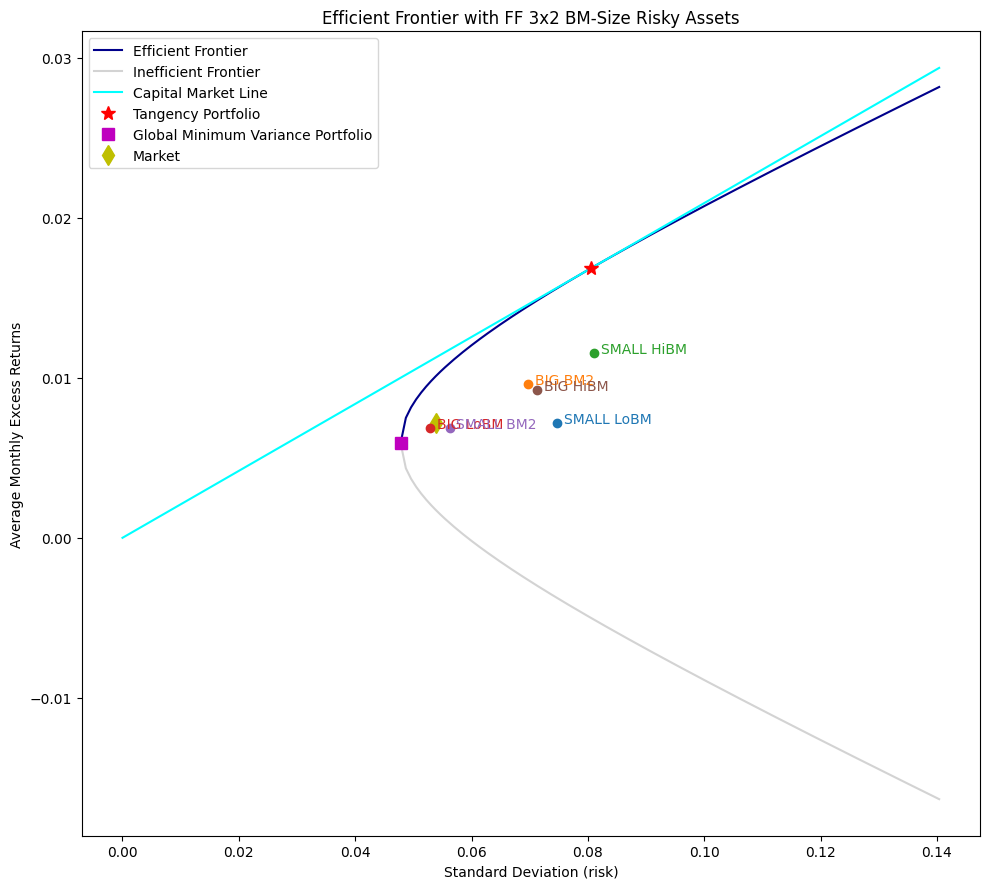

In [18]:
fig, ax = plt.subplots(figsize=(10, 9))
DataFrame(efficient).set_index('volatility').plot(ax=ax, color='darkblue')
DataFrame(frontier).set_index('volatility').plot(ax=ax, color='lightgrey')
ax.plot([0, np.sqrt(max(var_ticks))], [0, np.sqrt(max(var_ticks))*best_slope],
        color='cyan')  # capital market line
ax.plot(*tangency['coords'], "r*", ms=10)                    # tangency portfolio
ax.plot(np.sqrt(gmv['variance']), gmv['mean'], "ms", ms=8)   # GMV portfolio
ax.plot(np.sqrt(mkt['variance']), mkt['mean'], "yd", ms=10)  # market portfolio
plt.legend(['Efficient Frontier', 'Inefficient Frontier', 'Capital Market Line',
            'Tangency Portfolio', 'Global Minimum Variance Portfolio', 'Market'])
for c, r in enumerate(assets.itertuples()):   # risky assets
    ax.plot(r.volatility, r.mean, marker='o', color=f"C{c}")
    ax.annotate(text=r.Index, xy=(r.volatility, r.mean),
                xytext=(0.5, 0), textcoords="offset fontsize", color=f"C{c}")
ax.set_xlabel('Standard Deviation (risk)')
ax.set_ylabel('Average Monthly Excess Returns')
ax.set_title('Efficient Frontier with FF 3x2 BM-Size Risky Assets')
plt.tight_layout()

### CAPM

Sharpe, Lintner, and Mossin developed the CAPM, an equilibrium model that describes the relationship between risk and expected return for risky assets. The model assumes market efficiency and that investors optimize portfolios based on mean-variance principles.  

The CAPM posits that market equilibrium is reached when all investors hold combinations of the risk-free asset and the market portfolio. An asset's expected return is determined by its contribution to the market portfolio’s total risk, specifically its **systematic risk**, which cannot be diversified away. This risk is measured by beta:  

$$
\beta_i = \frac{\text{cov}(R_i, R_M)}{\text{var}(R_M)}
$$  

The **Security Market Line (SML)** represents the relationship between expected returns and beta:  

$$
E(R_i) = r_f + \beta_i (E[R_M] - r_f)
$$  


## Implied alphas

If a known portfolio allocation $W$ is an optimal solution to a mean-variance objective, the implied mean return inputs can be inferred given the covariance matrix. These **implied alphas**, proportional to $w^T \Sigma$, when used as expected returns in the optimization process, yield the same portfolio $W$.  


In [19]:
# market cap-weighted portfolio implied expected returns
capm = mkt['weights'].dot(sigma) * 2

In [20]:
# HML implied alphas
hml = Series(0.0, index=assets.index)
hml['BIG HiBM'] = 0.5
hml['SMALL HiBM'] = 0.5
hml['BIG LoBM'] = -0.5
hml['SMALL LoBM'] = -0.5
#hml = {'weights': hml.values}
#hml['variance'] = hml['weights'].dot(sigma).dot(hml['weights'])
#hml['coords'] = (np.sqrt(hml['variance']), hml['weights'].dot(mu))
alphas = hml.dot(sigma) * 2

In [21]:
pd.concat([Series(hml.values).rename('HML weights'),
           Series(alphas).rename('HML implied-alpha'),
           Series(mkt['weights']).rename('Market weights'),
           Series(capm).rename('CAPM equilibrium returns'),
           Series(mu).rename('historical mu'),
           Series(Series(alphas)/Series(capm)).rename('implied/capm')],
          axis=1, ignore_index=False)\
  .set_index(assets.index).T

,SMALL LoBM,BIG BM2,SMALL HiBM,BIG LoBM,SMALL BM2,BIG HiBM
HML weights,-0.500000,0.000000,0.500000,-0.500000,0.000000,0.500000
HML implied-alpha,0.000742,0.001827,0.003132,0.000277,0.001634,0.002967
Market weights,0.010631,0.017235,0.011753,0.693932,0.190550,0.075900
CAPM equilibrium returns,0.007044,0.006705,0.007413,0.005624,0.005733,0.006865
historical mu,0.007149,0.009629,0.011528,0.006860,0.006886,0.009252
implied/capm,0.105320,0.272514,0.422451,0.049240,0.285082,0.432198


In [22]:
# Correlations of alphas
DataFrame({'historical mu': np.corrcoef(alphas, mu)[0][-1],
           'capm equilbrium': np.corrcoef(alphas, capm)[0][-1]},
          index=['Correlation with implied alphas'])

,historical mu,capm equilbrium
Correlation with implied alphas,0.836893,0.610935


In [23]:
# Mean-variance optimization with HML-implied alphas
MeanVariance = alphas @ W - Var    
obj = cp.Problem(cp.Maximize(MeanVariance))
obj.solve(verbose=False)
DataFrame.from_records([hml.values, W.value], columns=labels,
                       index=['HML weights', 'mean-variance weights']).round(6)

,SMALL LoBM,BIG BM2,SMALL HiBM,BIG LoBM,SMALL BM2,BIG HiBM
HML weights,-0.5,0.0,0.5,-0.5,0.0,0.5
mean-variance weights,-0.5,0.0,0.5,-0.5,0.0,0.5


In [24]:
# Mean-variance optimization with CAPM-implied expected returns
MeanVariance = capm @ W - Var
obj = cp.Problem(cp.Maximize(MeanVariance))
obj.solve(verbose=False)
p = tangency_portfolio(mu=capm, sigma=sigma)
DataFrame.from_records([W.value, mkt['weights'], p['weights']], columns=labels,
                       index=['Market weights', 'mean-variance weights', 'formula'])

,SMALL LoBM,BIG BM2,SMALL HiBM,BIG LoBM,SMALL BM2,BIG HiBM
Market weights,0.010631,0.017235,0.011753,0.693932,0.19055,0.0759
mean-variance weights,0.010631,0.017235,0.011753,0.693932,0.19055,0.0759
formula,0.010631,0.017235,0.011753,0.693932,0.19055,0.0759


### Black-Litterman Model

Mean-variance portfolios are highly sensitive to input estimates, particularly expected returns. Errors in estimating expected returns have a far greater impact than errors in estimating variances and covariances. Black and Litterman (1992) proposed *shrinking* investor expectations toward equilibrium market returns to reduce sensitivity to estimation errors.  

In [25]:
active = tangency['weights'] - mkt['weights']
DataFrame.from_records([tangency['weights'], mkt['weights'], active], columns=labels,
                       index=['Tangency Portfolio Weights', 'Market Weights',
                              'Active Weights']).round(6)

,SMALL LoBM,BIG BM2,SMALL HiBM,BIG LoBM,SMALL BM2,BIG HiBM
Tangency Portfolio Weights,-2.807841,2.631802,1.023199,2.132014,-1.466995,-0.51218
Market Weights,0.010631,0.017235,0.011753,0.693932,0.190550,0.07590
Active Weights,-2.818472,2.614567,1.011446,1.438083,-1.657544,-0.58808


The Black-Litterman expected return estimates are computed as:  

$$
E[R] = [(\tau\Sigma)^{-1} + P^T \Omega^{-1} P]^{-1} [(\tau\Sigma)^{-1}\Pi + P^T \Omega^{-1} Q]
$$  

where:  
- $\tau$ is a confidence scalar for investor views versus equilibrium returns.  
- In Bayesian terms, $\tau$ represents uncertainty in equilibrium return estimation.  


In [26]:
tau = 0.05  # He and Litterman (1992) for a moderate amount of active risk
k = 1
Pi = capm.reshape((n, 1))          # equilbrium views: CAPM implied excess returns
P = (tangency['weights']).reshape((k, n))          # view portfolio weights
Q = (tangency['weights'].dot(mu)).reshape((k, k))  # portfolio view
Omega = np.diag(np.array(P.dot(sigma).dot(P.T)).reshape((k,k))) # uncertainty

In [27]:
def black_litterman(tau, Pi, Sigma, P, Q):
    """Returns black-litterman alphas"""
    def inv(x):
        """helper wraps over la.inv to handle scalar/1d inputs"""
        try:
            return la.inv(x)
        except:
            return np.array(1/x).reshape((1,1))
    return inv(inv(tau*Sigma)+P.T.dot(inv(Omega)).dot(P))\
        .dot(inv(tau*Sigma).dot(Pi) + P.T.dot(inv(Omega)).dot(Q))

In [28]:
bl = {'alphas': black_litterman(tau=tau, Pi=Pi, Sigma=sigma, P=P, Q=Q)}
bl |= tangency_portfolio(mu=bl['alphas'], sigma=sigma)
bl['mean'] = bl['weights'].dot(mu)    # express mean based on original mu
bl['tilt'] = bl['weights'] - mkt['weights']
print('Active Risk:', np.sqrt(bl['tilt'].T.dot(sigma).dot(bl['tilt'])))
DataFrame.from_dict({'Black-Litterman weights': bl['weights'], 
                     'Market weights': mkt['weights'], 'Active weights': bl['tilt']},
                     columns=labels, orient='index').round(6)

Active Risk: 0.0024824588797282025


,SMALL LoBM,BIG BM2,SMALL HiBM,BIG LoBM,SMALL BM2,BIG HiBM
Black-Litterman weights,-0.101900,0.121624,0.052136,0.751349,0.124370,0.05242
Market weights,0.010631,0.017235,0.011753,0.693932,0.190550,0.07590
Active weights,-0.112531,0.104390,0.040383,0.057417,-0.066179,-0.02348


In [29]:
# BL tilts the optimal weights towards the active positions in the view portfolio
bl['tilt'] / active

array([0.03992611, 0.03992611, 0.03992611, 0.03992611, 0.03992611,
       0.03992611])

With numerical solvers, constraints like no short-selling can be incorporated, and additional constraints can be iteratively added to achieve more reasonable portfolio allocations. 

In [30]:
Alpha = W @ mu

In [31]:
# Minimize variance to same expected return
obj = cp.Problem(cp.Minimize(Var), [cp.sum(W) == 1, W >= 0, Alpha >= bl['mean']])
obj.solve()
tilt = W.value - mkt['weights']
print('Minimize variance to achieve target return, with no short sales:')
print('Active Risk:', np.sqrt(tilt.T.dot(sigma).dot(tilt)))
DataFrame.from_dict({'Constrained weights': W.value,
                     'Market weights': mkt['weights'], 'Active weights': tilt},
                     columns=labels, orient='index').round(6)

Minimize variance to achieve target return, with no short sales:
Active Risk: 0.004263652598782702


,SMALL LoBM,BIG BM2,SMALL HiBM,BIG LoBM,SMALL BM2,BIG HiBM
Constrained weights,-0.000000,-0.000000,0.145177,0.790527,0.064296,0.0000
Market weights,0.010631,0.017235,0.011753,0.693932,0.190550,0.0759
Active weights,-0.010631,-0.017235,0.133425,0.096595,-0.126254,-0.0759


In [32]:
obj = cp.Problem(cp.Maximize(Alpha),
                 [cp.sum(W) == 1, W >= 0, Var <= bl['volatility']**2])
obj.solve()
tilt = W.value - mkt['weights']
print('Maximize return within target variance, with no short sales:')
print('Active Risk (annualized):', np.sqrt(tilt.T.dot(sigma).dot(tilt) * 12))
DataFrame.from_dict({'Constrained weights': W.value,
                     'Market weights': mkt['weights'], 'Active weights': tilt},
                     columns=labels, orient='index').round(6)

Maximize return within target variance, with no short sales:
Active Risk (annualized): 0.009003930083077559


,SMALL LoBM,BIG BM2,SMALL HiBM,BIG LoBM,SMALL BM2,BIG HiBM
Constrained weights,0.000000,0.000001,0.079741,0.778467,0.141791,0.0000
Market weights,0.010631,0.017235,0.011753,0.693932,0.190550,0.0759
Active weights,-0.010631,-0.017234,0.067988,0.084535,-0.048759,-0.0759


## Cross-sectional regressions

The Fama-MacBeth (1973) methodology estimates factor betas and risk premia in two steps:  

1. **Time-Series Regressions**: Estimate each asset’s beta by regressing its returns against proposed factor returns.  
2. **Cross-Sectional Regressions**: Estimate factor risk premia by regressing all asset returns against their betas across multiple time periods.  

This approach provides standard errors adjusted for cross-sectional correlation.  


### Testing the CAPM


We retrieve test asset returns and the risk-free rate. To test whether beta is priced, we examine whether higher-beta assets earn proportionally higher risk premia. We also test for **non-linearity** (beta-squared) and for the pricing of residual risk.  

In [33]:
factors = FFReader('F-F_Research_Data_Factors')[0] / 100  # risk-free rates
test_assets = FFReader('25_Portfolios_ME_BETA_5x5')
df = test_assets[1] / 100
df = df.sub(factors['RF'], axis=0).dropna().copy()

In [34]:
# unpivot the wide table to a long one
rets = df.stack()\
         .reset_index(name='ret')\
         .rename(columns={'level_1':'port', 'level_0':'Date'})

In [35]:
# estimate test assets' market betas from their time-series of returns
data = df.join(factors[['Mkt-RF']], how='left')
betas = least_squares(data, y=df.columns, x=['Mkt-RF'], stdres=True)
betas = betas.rename(columns={'Mkt-RF': 'BETA'})[['BETA', '_stdres']]

In [36]:
# collect test asset mean returns and betas
assets_df = betas[['BETA']].join(df.mean().rename('premiums')).sort_values('BETA')

In [37]:
# Orthogonalize polynomial (quadratic) beta^2 and residual-volatility features
betas['BETA2'] = smf.ols("I(BETA**2) ~ BETA",  data=betas).fit().resid
betas['RES'] = smf.ols("_stdres ~ BETA + BETA2", data=betas).fit().resid
r = rets.join(betas, on='port').sort_values(['port', 'Date'], ignore_index=True)

In [38]:
# run monthly Fama-MacBeth cross-sectional regressions
fm = r.groupby(by='Date')\
      .apply(least_squares, y=['ret'], x=['BETA', 'BETA2', 'RES'])

/tmp/ipykernel_1785309/3663017786.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(least_squares, y=['ret'], x=['BETA', 'BETA2', 'RES'])


In [39]:
# compute time-series means and standard errors of the Fama-MacBeth coefficients
out = DataFrame(dict(mean=fm.mean(), stderr=fm.sem(), tstat=fm.mean()/fm.sem())).T

In [40]:
print("Monthly Cross-sectional Regressions" +
      f" {min(rets['Date'])} to {max(rets['Date'])}")
out

Monthly Cross-sectional Regressions 1963-07 to 2024-12


,_intercept,BETA,BETA2,RES
mean,0.007817,0.000124,-0.008395,0.121528
stderr,0.001535,0.002255,0.002544,0.060507
tstat,5.091416,0.054945,-3.299643,2.008509


__Clustered standard errors__

Alternative corrections for standard errors account for both time-series and cross-sectional correlation, such as double clustering by firm and year.  

In [41]:
### Compare uncorrected to robust cov
ls = smf.ols("ret ~ BETA + BETA2 + RES", data=r).fit()
print(ls.summary())
# print(ls.get_robustcov_results('HC0').summary())
# print(ls.get_robustcov_results('HAC', maxlags=6).summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.554
Date:                Mon, 03 Mar 2025   Prob (F-statistic):             0.0535
Time:                        07:02:21   Log-Likelihood:                 25722.
No. Observations:               18450   AIC:                        -5.144e+04
Df Residuals:                   18446   BIC:                        -5.141e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0078      0.002      4.174      0.0

In [42]:
print(ls.get_robustcov_results('hac-panel',
                               groups=r['port'],
                               maxlags=6).summary())
# print(ls.get_robustcov_results('cluster', groups=r['port']).summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.636
Date:                Mon, 03 Mar 2025   Prob (F-statistic):              0.207
Time:                        07:02:21   Log-Likelihood:                 25722.
No. Observations:               18450   AIC:                        -5.144e+04
Df Residuals:                   18446   BIC:                        -5.141e+04
Df Model:                           3                                         
Covariance Type:            hac-panel                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0078      0.002      4.003      0.0

### Factor risk models

Beginning with Barra in the mid-1970's, industry practitioners have employed cross-sectional models to forecast risk premia and measure risk factors. Monthly cross-sectional regressions are run on standardized individual stock characteristics such as:  
- **Size**: Market capitalization rank  
- **Value**: Book-to-market ratio  
- **Momentum**: 12-month return (excluding past month)  
- **Reversal**: 1-month return reversal  

The stock characteristic values are winsored at their 5% tails to reduce the influence of outliers.  These risk premia are interpreted as returns on dollar-neutral portfolios with unit exposure to a characteristic and zero exposure to other characteristics. 

Their estimated risk premiums are compared to Fama-French research factor returns (which are constructed as returns from long-short spread portfolios).

In [43]:
# Construct momentum and reversal signals

rebalbeg = 19640601
rebalend = LAST_DATE
# preload CRSP monthly into memory
monthly = CRSPBuffer(stocks=crsp, dataset='monthly',
                     fields=['ret', 'retx', 'prc'],
                     beg=bd.begmo(rebalbeg, -13),
                     end=bd.endmo(rebalend, 1))    # load with extra months around rebaldates


In [44]:
intervals = {'mom': (2, 12, 1), 'strev': (1, 1, -1)}  # signal: (start, end, sign)
for label, past in intervals.items():
    out = []
    rebaldates = bd.date_range(bd.endmo(rebalbeg), rebalend, 'endmo')
    for rebaldate in tqdm(rebaldates, total=len(rebaldates)):
        start = bd.endmo(rebaldate, -past[1])
        beg1 = bd.offset(start, 1)
        end1 = bd.endmo(rebaldate, 1-past[0])
        df = monthly.get_universe(end1)
        # require data available at start month and at last month (universe)
        df['start'] = monthly.get_section(dataset='monthly',
                                          fields=['ret'],
                                          date_field='date',
                                          date=start).reindex(df.index)
        df[label] = past[2] * monthly.get_ret(beg1, end1).reindex(df.index)
        df['permno'] = df.index
        df['rebaldate'] = rebaldate
        df = df.dropna(subset=['start'])
        out.append(df[['rebaldate', 'permno', label]]) # append rows
    out = pd.concat(out, axis=0, ignore_index=True)
    n = signals.write(out, label, overwrite=True)

100%|██████████| 726/726 [00:41<00:00, 17.50it/s]


100%|██████████| 726/726 [00:31<00:00, 22.93it/s]


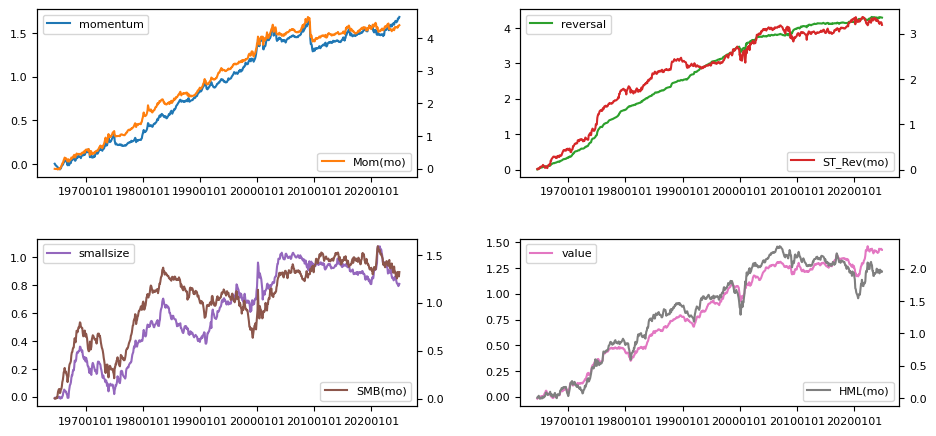

In [45]:
rebalbeg = 19640601
rebalend = LAST_DATE
rebaldates = crsp.bd.date_range(rebalbeg, rebalend, 'endmo')
loadings = dict()

# preload signal values
sf = {key: SignalsFrame(signals.read(key)) for key in ['hml', 'mom', 'strev']}

for pordate in tqdm(rebaldates):           # retrieve signal values every month
    date = bd.june_universe(pordate)
    univ = crsp.get_universe(date)
    smb = univ['capco'].rank(ascending=False).div(len(univ)).rename('smallsize')
    hml = sf['hml']('hml', date, bd.endmo(date, -12))['hml'].rename('value')
    #beta = signals('beta', pordate, bd.begmo(pordate))['beta']*2/3 + 1/3 #shrink
    mom = sf['mom']('mom', pordate)['mom'].rename('momentum')
    strev = sf['strev']('strev', pordate)['strev'].rename('reversal')
    df = pd.concat((strev, hml, smb, mom), join='inner', axis=1)\
           .reindex(univ.index).dropna()
    loadings[pordate] = winsorize(df, quantiles=[0.05, 0.95])

# Compute coefficients from FM cross-sectional regressions
monthly = CRSPBuffer(stocks=crsp, dataset='monthly', fields=['ret'],
                     beg=bd.begmo(rebalbeg, -13), end=bd.endmo(rebalend, 1))

riskpremium = RiskPremium(sql=user, bench=bench, rf='RF', end=LAST_DATE)
out = riskpremium(stocks=monthly, loadings=loadings,
                  standardize=['value' ,'smallsize', 'momentum', 'reversal'])
     
# Compare time series of risk premiums to portfolio-sort benchmark eturns
benchnames = {'momentum': 'Mom(mo)',
              'reversal': 'ST_Rev(mo)',
              'smallsize':'SMB(mo)',
              'value': 'HML(mo)'}
out = riskpremium.fit(benchnames.values())  # to compare portfolio-sorts
riskpremium.plot(benchnames)


In [46]:
# Summarize time-series means of Fama-Macbeth risk premiums
df = out[0]
df['tvalue'] = df['mean']/df['stderr']
df['sharpe'] = np.sqrt(12) * df['mean']/df['std']
print("Fama-MacBeth Cross-sectional Regression Risk Premiums")
df.round(4)

Fama-MacBeth Cross-sectional Regression Risk Premiums


Factor Returns,mean,stderr,std,count,tvalue,sharpe
reversal,0.0059,0.0005,0.0143,725,11.1314,1.4321
value,0.0020,0.0004,0.0112,725,4.7378,0.6095
smallsize,0.0011,0.0007,0.0178,725,1.6812,0.2163
momentum,0.0023,0.0007,0.0175,725,3.5671,0.4589


In [47]:
# Summarize time-series means of Fama-French portfolio-sort returns
df = out[2]
df['tvalue'] = df['mean']/df['stderr']
df['sharpe'] = np.sqrt(12) * df['mean']/df['std']
print("Fama-French Portfolio-Sorts")
df.round(4)

Fama-French Portfolio-Sorts


Benchmarks,mean,stderr,std,count,tvalue,sharpe
Mom(mo),0.0061,0.0016,0.0423,725,3.8647,0.4972
ST_Rev(mo),0.0044,0.0012,0.0315,725,3.7562,0.4833
SMB(mo),0.0018,0.0011,0.0308,725,1.5941,0.2051
HML(mo),0.0027,0.0011,0.0301,725,2.4116,0.3103


In [48]:
# Show correlation of returns
print('Correlation of FM-Crossectional Risk Premiums and FF-Sorted Portfolio Returns')
pd.concat([out[1].join(out[4]), out[4].T.join(out[3])], axis=0).round(3)

Correlation of FM-Crossectional Risk Premiums and FF-Sorted Portfolio Returns


,reversal,value,smallsize,momentum,Mom(mo),ST_Rev(mo),SMB(mo),HML(mo)
reversal,1.000,0.016,0.077,-0.444,-0.388,0.793,0.145,0.051
value,0.016,1.000,-0.227,-0.194,-0.169,-0.019,-0.203,0.810
smallsize,0.077,-0.227,1.000,-0.003,0.133,0.008,0.517,-0.151
momentum,-0.444,-0.194,-0.003,1.000,0.884,-0.279,-0.066,-0.207
Mom(mo),-0.388,-0.169,0.133,0.884,1.000,-0.307,-0.047,-0.195
ST_Rev(mo),0.793,-0.019,0.008,-0.279,-0.307,1.000,0.178,0.013
SMB(mo),0.145,-0.203,0.517,-0.066,-0.047,0.178,1.000,-0.150
HML(mo),0.051,0.810,-0.151,-0.207,-0.195,0.013,-0.150,1.000


## Nonlinear regression

### Feature transformations

A simple way to directly extend the linear model to accommodate
non-linear relationships, using polynomial regression, is to include
transformed versions of the predictors in the model, such as a
quadratic term or several polynomial functions of the predictors, 
and use standard linear regression to estimate coefficients in order to produce a non-linear fit.  The CAPM predicts that these coefficients on non-linear transformations of beta should be zero.

Raw polynomial terms may be highly correlated with each other: _Orthogonal polynomials_ transform the raw data matrix of polynomial terms to another whose columns are a basis of orthogonal terms which span the same column space. For example, regress the second predictor on the first and replace its column with the residuals, then regress the third predictor on the first two and replace its column with the residuals, and so on.

Other feature transformation approaches include:
- dummy or binary indicator variable
- categorical variables with two or more levels
- binarization or turning a categorical variable into several binary variables (4)
- Legendre polynomals which are defined as a system of orthogonal polynomials over the interval $[-1, 1]$ 
-  interaction term constructed by computing the product of the values of the two variables to capture the effect that response of one predictor is dependent on the value of another predictor.



### Kernel regression

If there are already a large number of $k$ features, then polynomial transformations, say up to degree $d,$  may be computational expensive since we could be working in $O(k^d)$ dimensional space.  Fortunately, many high-dimensional feature mappings, denoted $\phi(x)$, correspond to kernel functions $K$, where model fitting and prediction calculations only require inner products of these kernel matrices and we never need to explicitly represent vectors in the very high-dimensional feature space.  For example, the kernel $K(x, y) = (x^Ty + c)^d$, which requires only $O(k)$ to compute, expands to the feature space corresponding with all polynomial terms up to degree $d$ of the features in $x$ and $y$. 

Kernels can be viewed as similarity metrics, that measure how close together the feature maps $\phi(x)$ and $\phi(y)$ are. The radial basis function (RBF), or Gaussian, kernel uses distance in Euclidean space which corresponds to an infinite-dimension feature mapping.

This application of Kernel functions that can be efficiently computed, where only their inner products are needed without ever explicitly computing their corresponding feature vectors in very high-dimensional space, has come to be known as the __kernel trick__.


In [49]:
factors

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07,0.0296,-0.0256,-0.0243,0.0022
1926-08,0.0264,-0.0117,0.0382,0.0025
1926-09,0.0036,-0.0140,0.0013,0.0023
1926-10,-0.0324,-0.0009,0.0070,0.0032
1926-11,0.0253,-0.0010,-0.0051,0.0031
...,...,...,...,...
2024-08,0.0161,-0.0355,-0.0113,0.0048
2024-09,0.0174,-0.0017,-0.0259,0.0040
2024-10,-0.0097,-0.0101,0.0089,0.0039



The concave shape of the fitted kernel regression curve is consistent with the negative average premiums observed for the squared-beta factor in earlier Fama-MacBeth tests.

/tmp/ipykernel_1785309/182542393.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bandwidth = float((max(X_train) - min(X_train)) * 4 / len(X_train))


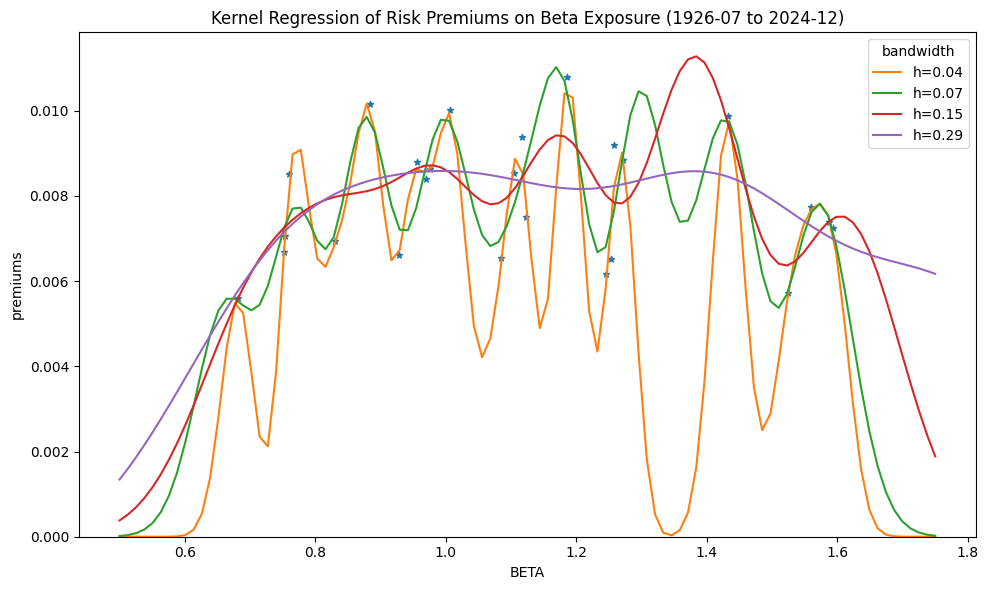

In [50]:
y_train = assets_df[['premiums']].values
X_train = assets_df[['BETA']].values
X_test = np.linspace(0.5, 1.75, 100).reshape(-1, 1)
bandwidth = float((max(X_train) - min(X_train)) * 4 / len(X_train))

fig, ax = plt.subplots(figsize=(10,6))
legend = []
color = 1
for h in [0.25, 0.5, 1, 2]:
    for alpha in [0.01]:
        model = KernelRidge(alpha=alpha, kernel='rbf', gamma=1/(h*bandwidth)**2)
        model.fit(X=X_train, y=y_train)
        y_pred = model.predict(X_test)
        ax.plot(X_test, y_pred, ls='-', color=f"C{color}")
        legend.append(f"h={h*bandwidth:.2f}")
        color += 1
# scatter plot actual                                                                        
assets_df.plot(x='BETA', y='premiums', kind='scatter', ax=ax, marker="*", color="C0")
ax.set_ylim(bottom=0)
plt.legend(legend, loc='best', title='bandwidth')
plt.title('Kernel Regression of Risk Premiums on Beta Exposure' +
          f" ({factors.index[0]} to {factors.index[-1]})")
plt.tight_layout()



**References:**

H. M. Markowitz, “Portfolio Selection,” Journal of Finance 7, 1952, pp. 77–91.

W. F. Sharpe, “Capital Asset Prices: A Theory of Market Equilibrium under Conditions of Risk,” Journal of Finance 19, 1964, pp. 425–442. 

J. Lintner, “Security Prices, Risk and Maximal Gains from Diversification,” Journal of Finance 20, 1965, pp. 587–615, and J. Mossin, “Equilibrium in a Capital Asset Market,” Econometrica 34, 1966, pp, 768–783. 

Fama, Eugene F.; MacBeth, James D. (1973). "Risk, Return, and Equilibrium: Empirical Tests". Journal of Political Economy. 81 (3): 607–636.

Black, F., and R. Litterman. 1992. “Global Portfolio Optimization.” Financial Analysts Journal, vol. 48, no. 5 (September/October): 28-43

He, G., and R. Litterman. 1999. “The Intuition Behind Black-Litterman Model Portfolios.” Goldman Sachs Investment Management Series.

R. C. Jones, T. Lim and P. J. Zangari. “The Black-Litterman Model for Structured Equity Portfolios,” Journal of Portfolio Management, Vol. 33, No. 2, 2007, pp. 24-43. doi:10.3905/jpm.2007.674791

FRM Part I Exam Book Foundations of Risk Management Ch. 5.